In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.6049

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - loss: 0.4928
Average validation loss: 0.5133628845214844
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - loss: 0.4928 - val_loss: 0.5134
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 558ms/step - loss: 0.3781 - val_loss: 0.5134
Average validation loss: 0.49756428599357605
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 573ms/step - loss: 0.3781 - val_loss: 0.5055
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 523ms/step - loss: 0.3017 - val_loss: 0.5055
Average validation loss: 0.19786891341209412
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 534ms/step - loss: 0.3017 - val_loss: 0.4029
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 829ms/step - loss: 0.0564
Average validation loss: 0.7442168593406677
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 844ms/step - loss: 0.0564 - val_loss: 0.7442
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 829ms/step - loss: 0.0559 - val_loss: 0.7442
Average validation loss: 0.4361843317747116
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 840ms/step - loss: 0.0559 - val_loss: 0.5902
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 903ms/step - loss: 0.0517 - val_loss: 0.5902
Average validation loss: 0.16703315824270248
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 914ms/step - loss: 0.0517 - val_loss: 0.4491
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 880ms/step - loss: 0.0300
Average validation loss: 0.03789607901126146
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 891ms/step - loss: 0.0300 - val_loss: 0.0379
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 831ms/step - loss: 0.0248 - val_loss: 0.0379
Average validation loss: 0.041865766048431396
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 847ms/step - loss: 0.0248 - val_loss: 0.0399
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 816ms/step - loss: 0.0231 - val_loss: 0.0399
Average validation loss: 0.035732331996162735
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 833ms/step - loss: 0.0231 - val_loss: 0.0385
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_15.pth'.
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 816ms/step - loss: 0.0213 - val_loss: 0.0385
Avera

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 852ms/step - loss: 0.0097
Average validation loss: 0.018176772049628198
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 866ms/step - loss: 0.0097 - val_loss: 0.0182
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 895ms/step - loss: 0.0099 - val_loss: 0.0182
Average validation loss: 0.009835574368480593
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 907ms/step - loss: 0.0099 - val_loss: 0.0140
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 895ms/step - loss: 0.0095 - val_loss: 0.0140
Average validation loss: 0.006928041228093207
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 905ms/step - loss: 0.0095 - val_loss: 0.0116
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segform

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 891ms/step - loss: 0.0170
Average validation loss: 0.0068932506954297425
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 906ms/step - loss: 0.0170 - val_loss: 0.0069
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 838ms/step - loss: 0.0126 - val_loss: 0.0069
Average validation loss: 0.007149503193795681
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 855ms/step - loss: 0.0126 - val_loss: 0.0070
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 830ms/step - loss: 0.0107 - val_loss: 0.0070
Average validation loss: 0.009778732061386108
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 846ms/step - loss: 0.0107 - val_loss: 0.0079
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 818ms/step - loss: 0.0096 - val_loss: 0.0079
Average validation loss: 0.005608376313466579
20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 834ms/step - loss: 0.0096 - val_loss: 0.0074
Saved model weights to 'c:\天_11157065

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 843ms/step - loss: 0.0234
Average validation loss: 0.016125955463697512
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 855ms/step - loss: 0.0234 - val_loss: 0.0161
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 883ms/step - loss: 0.0165 - val_loss: 0.0161
Average validation loss: 0.008827950689010322
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 901ms/step - loss: 0.0165 - val_loss: 0.0125
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 825ms/step - loss: 0.0145 - val_loss: 0.0125
Average validation loss: 0.006688735370213787
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 842ms/step - loss: 0.0145 - val_loss: 0.0105
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segform

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 847ms/step - loss: 0.0174
Average validation loss: 0.019034792273305356
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 861ms/step - loss: 0.0174 - val_loss: 0.0190
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 841ms/step - loss: 0.0127 - val_loss: 0.0190
Average validation loss: 0.009635231047286651
40/40 ━━━━━━━━━━━━━━━━━━━━ 69s 855ms/step - loss: 0.0127 - val_loss: 0.0143
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 105s 897ms/step - loss: 0.0106 - val_loss: 0.0143
Average validation loss: 0.019352252868702634
40/40 ━━━━━━━━━━━━━━━━━━━━ 105s 910ms/step - loss: 0.0106 - val_loss: 0.0160
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 139s 852ms/step - loss: 0.0091 - val_loss: 0.0160
A

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 836ms/step - loss: 0.0113
Average validation loss: 0.02035041820878784
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 850ms/step - loss: 0.0113 - val_loss: 0.0204
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 840ms/step - loss: 0.0091 - val_loss: 0.0204
Average validation loss: 0.004992520679176475
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 854ms/step - loss: 0.0091 - val_loss: 0.0127
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 121s 815ms/step - loss: 0.0074 - val_loss: 0.0127
Average validation loss: 0.005475189534384602
48/48 ━━━━━━━━━━━━━━━━━━━━ 122s 827ms/step - loss: 0.0074 - val_loss: 0.0103
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 162s 830ms/step - loss: 0.0064 - val_loss: 0.0103
Av

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 862ms/step - loss: 0.0073
Average validation loss: 0.011127258468020176
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 876ms/step - loss: 0.0073 - val_loss: 0.0111
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 95s 823ms/step - loss: 0.0062 - val_loss: 0.0111
Average validation loss: 0.005649482565266746
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 837ms/step - loss: 0.0062 - val_loss: 0.0084
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 827ms/step - loss: 0.0053 - val_loss: 0.0084
Average validation loss: 0.004818640050611326
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 841ms/step - loss: 0.0053 - val_loss: 0.0072
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 838ms/step - loss: 0.0057
Average validation loss: 0.01493860999471508
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 851ms/step - loss: 0.0057 - val_loss: 0.0149
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 109s 844ms/step - loss: 0.0047 - val_loss: 0.0149
Average validation loss: 0.005364591339457547
64/64 ━━━━━━━━━━━━━━━━━━━━ 109s 858ms/step - loss: 0.0047 - val_loss: 0.0102
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 162s 826ms/step - loss: 0.0042 - val_loss: 0.0102
Average validation loss: 0.022139494685688987
64/64 ━━━━━━━━━━━━━━━━━━━━ 163s 839ms/step - loss: 0.0042 - val_loss: 0.0141
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 216s 824ms/step - loss: 0.0039 - val_loss: 0.0141


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 834ms/step - loss: 0.0045
Average validation loss: 0.011997242603683844
72/72 ━━━━━━━━━━━━━━━━━━━━ 61s 847ms/step - loss: 0.0045 - val_loss: 0.0120
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 120s 823ms/step - loss: 0.0041 - val_loss: 0.0120
Average validation loss: 0.010263500111048214
72/72 ━━━━━━━━━━━━━━━━━━━━ 121s 837ms/step - loss: 0.0041 - val_loss: 0.0111
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 181s 826ms/step - loss: 0.0035 - val_loss: 0.0111
Average validation loss: 0.046426044340478256
72/72 ━━━━━━━━━━━━━━━━━━━━ 182s 839ms/step - loss: 0.0035 - val_loss: 0.0229
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 241s 831ms/step - loss: 0.0032 - val_loss: 0.0229

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 872ms/step - loss: 0.0058
Average validation loss: 0.06968463703960878
80/80 ━━━━━━━━━━━━━━━━━━━━ 71s 886ms/step - loss: 0.0058 - val_loss: 0.0697
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 138s 843ms/step - loss: 0.0044 - val_loss: 0.0697
Average validation loss: 0.004783072722784709
80/80 ━━━━━━━━━━━━━━━━━━━━ 139s 857ms/step - loss: 0.0044 - val_loss: 0.0372
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 207s 851ms/step - loss: 0.0037 - val_loss: 0.0372
Average validation loss: 0.0025732222653459757
80/80 ━━━━━━━━━━━━━━━━━━━━ 208s 864ms/step - loss: 0.0037 - val_loss: 0.0257
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_s

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 81s 839ms/step - loss: 0.0063
Average validation loss: 0.013886997073617144
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 853ms/step - loss: 0.0063 - val_loss: 0.0139
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 162s 832ms/step - loss: 0.0050 - val_loss: 0.0139
Average validation loss: 0.011919756975354781
96/96 ━━━━━━━━━━━━━━━━━━━━ 163s 846ms/step - loss: 0.0050 - val_loss: 0.0129
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 243s 828ms/step - loss: 0.0043 - val_loss: 0.0129
Average validation loss: 0.03721420324048571
96/96 ━━━━━━━━━━━━━━━━━━━━ 244s 842ms/step - loss: 0.0043 - val_loss: 0.0210
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 323s 824ms/step - loss: 0.0040 - val_loss: 0.021

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 104s 864ms/step - loss: 0.0098
Average validation loss: 0.005187031728564761
120/120 ━━━━━━━━━━━━━━━━━━━━ 105s 877ms/step - loss: 0.0098 - val_loss: 0.0052
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 211s 877ms/step - loss: 0.0074 - val_loss: 0.0052
Average validation loss: 0.008986754222617795
120/120 ━━━━━━━━━━━━━━━━━━━━ 212s 891ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 319s 891ms/step - loss: 0.0063 - val_loss: 0.0071
Average validation loss: 0.008066459490995234
120/120 ━━━━━━━━━━━━━━━━━━━━ 321s 904ms/step - loss: 0.0063 - val_loss: 0.0074
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 426s 873ms/step - loss: 0.0055 - val_loss: 0.0074
Average validation loss: 0.04279048756385843
120/120 ━━━━━━━━━━━━━━━━━━━━ 427s 887ms/step - loss: 0.0055 - val_loss: 0.0163
Epoch 5/10
120

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 119s 828ms/step - loss: 0.0083
Average validation loss: 0.008694461630916016
144/144 ━━━━━━━━━━━━━━━━━━━━ 121s 841ms/step - loss: 0.0083 - val_loss: 0.0087
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 240s 827ms/step - loss: 0.0066 - val_loss: 0.0087
Average validation loss: 0.012711646993314693
144/144 ━━━━━━━━━━━━━━━━━━━━ 242s 840ms/step - loss: 0.0066 - val_loss: 0.0107
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 361s 824ms/step - loss: 0.0057 - val_loss: 0.0107
Average validation loss: 0.054969501558743
144/144 ━━━━━━━━━━━━━━━━━━━━ 363s 838ms/step - loss: 0.0057 - val_loss: 0.0255
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 482s 830ms/step - loss: 0.0051 - val_loss: 0.0255
Average validation loss: 0.020261731473712845
144/144 ━━━━━━━━━━━━━━━━━━━━ 484s 843ms/step - loss: 0.0051 - val_loss: 0.0242
Epoch 5/10
144/1

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 132s 828ms/step - loss: 0.0048
Average validation loss: 0.0072249015458510256
160/160 ━━━━━━━━━━━━━━━━━━━━ 134s 841ms/step - loss: 0.0048 - val_loss: 0.0072
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 262s 796ms/step - loss: 0.0039 - val_loss: 0.0072
Average validation loss: 0.0086471985137905
160/160 ━━━━━━━━━━━━━━━━━━━━ 264s 809ms/step - loss: 0.0039 - val_loss: 0.0079
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 391s 798ms/step - loss: 0.0035 - val_loss: 0.0079
Average validation loss: 0.0053910302318399776
160/160 ━━━━━━━━━━━━━━━━━━━━ 394s 811ms/step - loss: 0.0035 - val_loss: 0.0071
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_200.pth'.
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 523s 809ms/step - loss: 0.0033 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 802ms/step - loss: 0.0055
Average validation loss: 0.010951092738405346
200/200 ━━━━━━━━━━━━━━━━━━━━ 163s 815ms/step - loss: 0.0055 - val_loss: 0.0110
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 322s 797ms/step - loss: 0.0045 - val_loss: 0.0110
Average validation loss: 0.007579710190184414
200/200 ━━━━━━━━━━━━━━━━━━━━ 325s 809ms/step - loss: 0.0045 - val_loss: 0.0093
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 485s 802ms/step - loss: 0.0038 - val_loss: 0.0093
Average validation loss: 0.009504389714966237
200/200 ━━━━━━━━━━━━━━━━━━━━ 488s 814ms/step - loss: 0.0038 - val_loss: 0.0093
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 648s 800ms/step - loss: 0.0037 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 809ms/step - loss: 0.0041
Average validation loss: 0.062015411218597875
240/240 ━━━━━━━━━━━━━━━━━━━━ 197s 822ms/step - loss: 0.0041 - val_loss: 0.0620
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 394s 819ms/step - loss: 0.0033 - val_loss: 0.0620
Average validation loss: 0.004681861353543093
240/240 ━━━━━━━━━━━━━━━━━━━━ 397s 831ms/step - loss: 0.0033 - val_loss: 0.0333
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_0\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 589s 799ms/step - loss: 0.0028 - val_loss: 0.0333
Average validation loss: 0.008854670928000867
240/240 ━━━━━━━━━━━━━━━━━━━━ 592s 812ms/step - loss: 0.0028 - val_loss: 0.0252
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 785s 803ms/step - loss: 0.0026 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.14347952455282212, 0.08315072383964434, 0.02011708845073978, 0.0345226195990108, 0.011060728974523955, 0.019003681336762383, 0.011943849066650726, 0.01057009344920516, 0.021835580045569385, 0.016834134646742313, 0.019372666613344337, 0.0067124259334086665, 0.008956292955566216, 0.020791823447187198, 0.010184114465754983, 0.007138990032973591, 0.009096164475517652, 0.009788023698523524]
std_val_losses =  [0.10450119146771841, 0.12468211397876275, 0.016750025786588695, 0.10228817059649202, 0.014815262815119194, 0.036506546671793066, 0.012255469205362345, 0.01685647993746102, 0.04169367987165363, 0.022926994013262838, 0.042798429076968916, 0.010741500660590243, 0.008137203362753283, 0.054789879051716096, 0.009699513300664847, 0.00806966454160938, 0.007241594650656613, 0.013020817174605969]


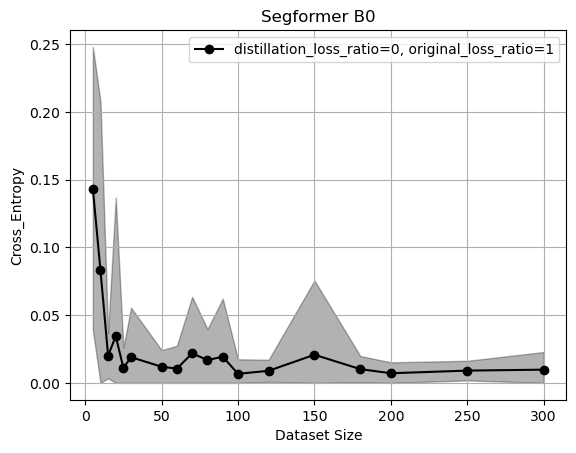

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()